In [1]:
import numpy as np

from pulser.register.register_layout import RegisterLayout
from pulser import Sequence, Pulse

# 1. Arbitrary Layouts

In [2]:
np.random.seed(301122)  # Keeps results consistent between runs
traps = np.random.randint(0, 30, size=(20, 2))
traps = traps - np.mean(traps, axis=0)

# Creating the layout
layout = RegisterLayout(traps, slug="random_20")

The layout slug: random_20
The unique ID layout: RegisterLayout_0119932f3fc4d0cf580fff471f18baad23e982084be676487841b8a4be41c978


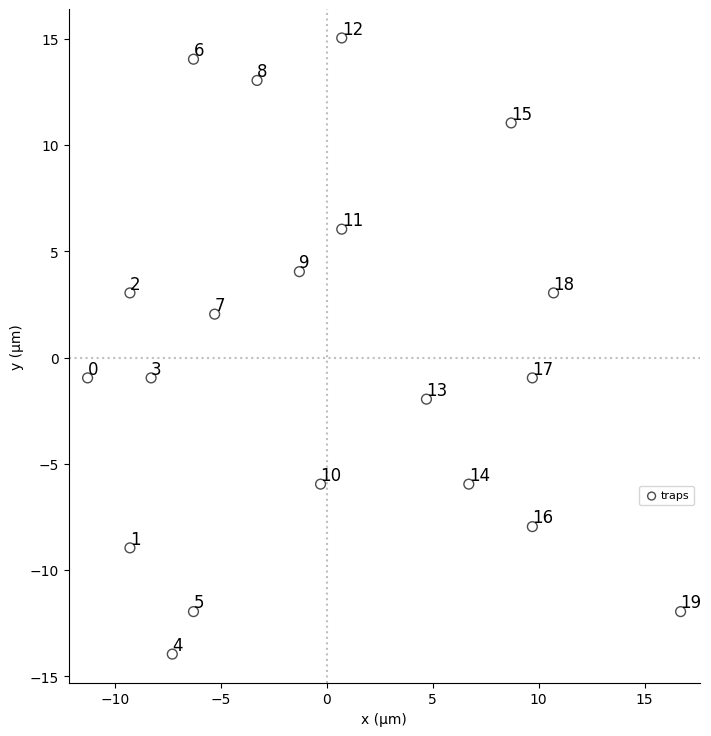

In [3]:
print("The layout slug:", layout)
print("The unique ID layout:", repr(layout))
layout.draw()

# 2. Register definition

2.1. Defined by the trap IDs:

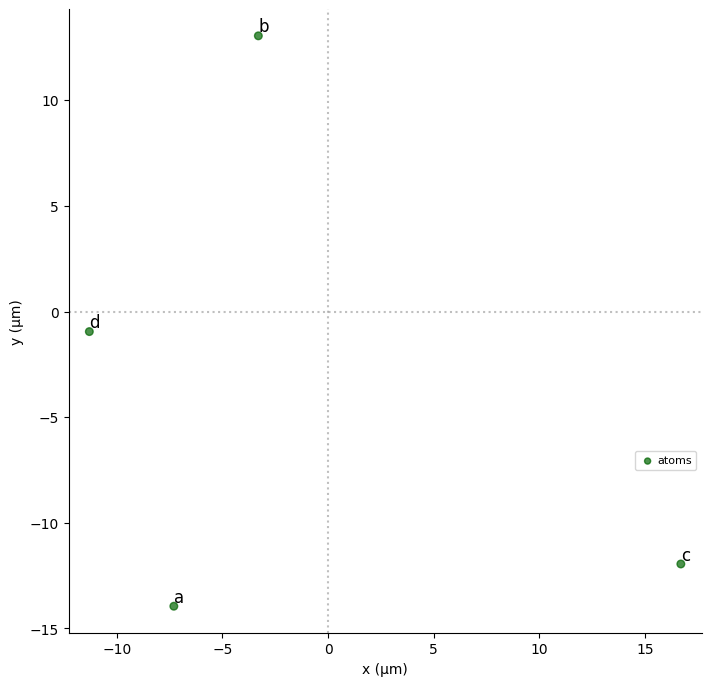

In [4]:
trap_ids = [4, 8, 19, 0]
reg1 = layout.define_register(*trap_ids, qubit_ids=["a", "b", "c", "d"])
reg1.draw()

In [5]:
reg1.layout

RegisterLayout_0119932f3fc4d0cf580fff471f18baad23e982084be676487841b8a4be41c978

2.2 Defined from the trap coordinates

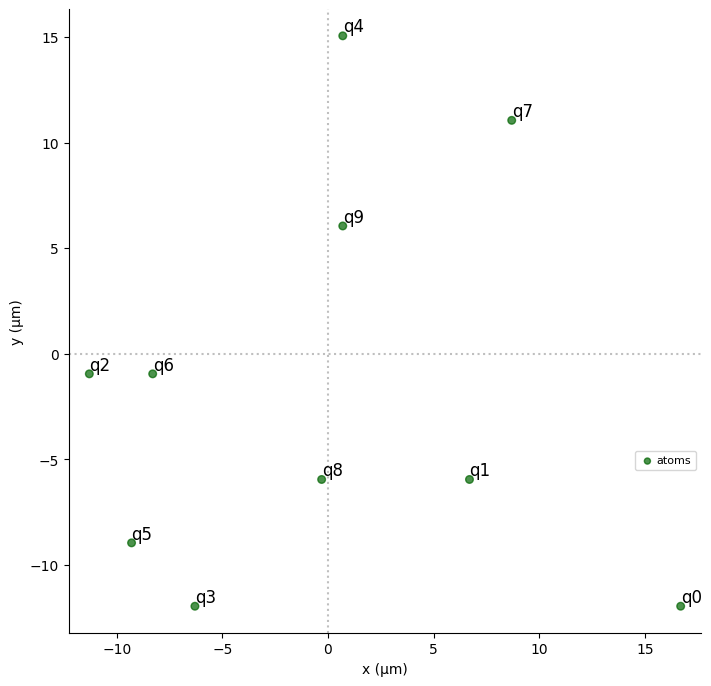

In [6]:
some_coords = layout.coords[
    np.random.choice(np.arange(layout.number_of_traps), size=10, replace=False)
]
trap_ids = layout.get_traps_from_coordinates(*some_coords)
reg2 = layout.define_register(*trap_ids)
reg2.draw()

# 3. Special layouts

In [7]:
from pulser.register.special_layouts import (
    SquareLatticeLayout,
    TriangularLatticeLayout,
)

3.1 SquareLatticeLayout

SquareLatticeLayout(7x4, 5.0µm)


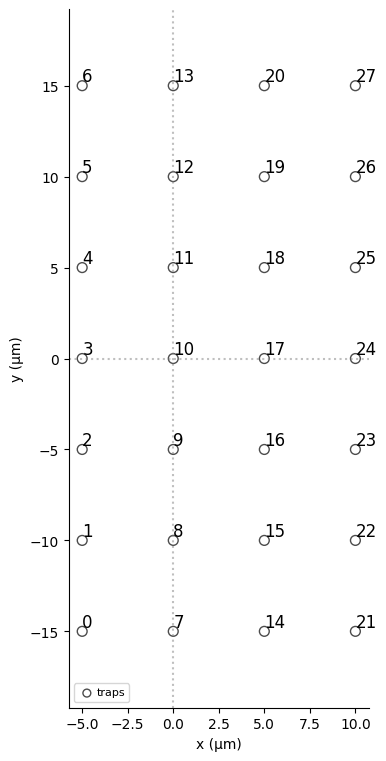

In [8]:
square_layout = SquareLatticeLayout(7, 4, spacing=5)
print(square_layout)
square_layout.draw()

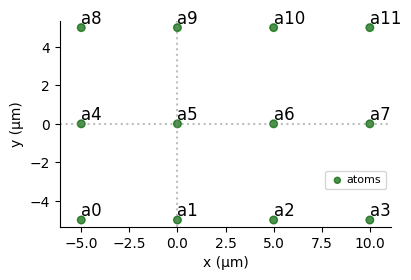

In [9]:
square_layout.rectangular_register(rows=3, columns=4, prefix="a").draw()

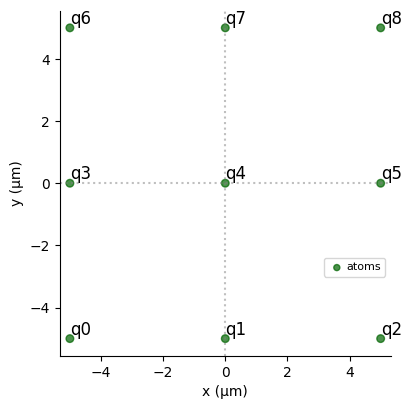

In [10]:
square_layout.square_register(side=3).draw()



3.2 TriangularLatticeLayout

TriangularLatticeLayout(100, 5.0µm)


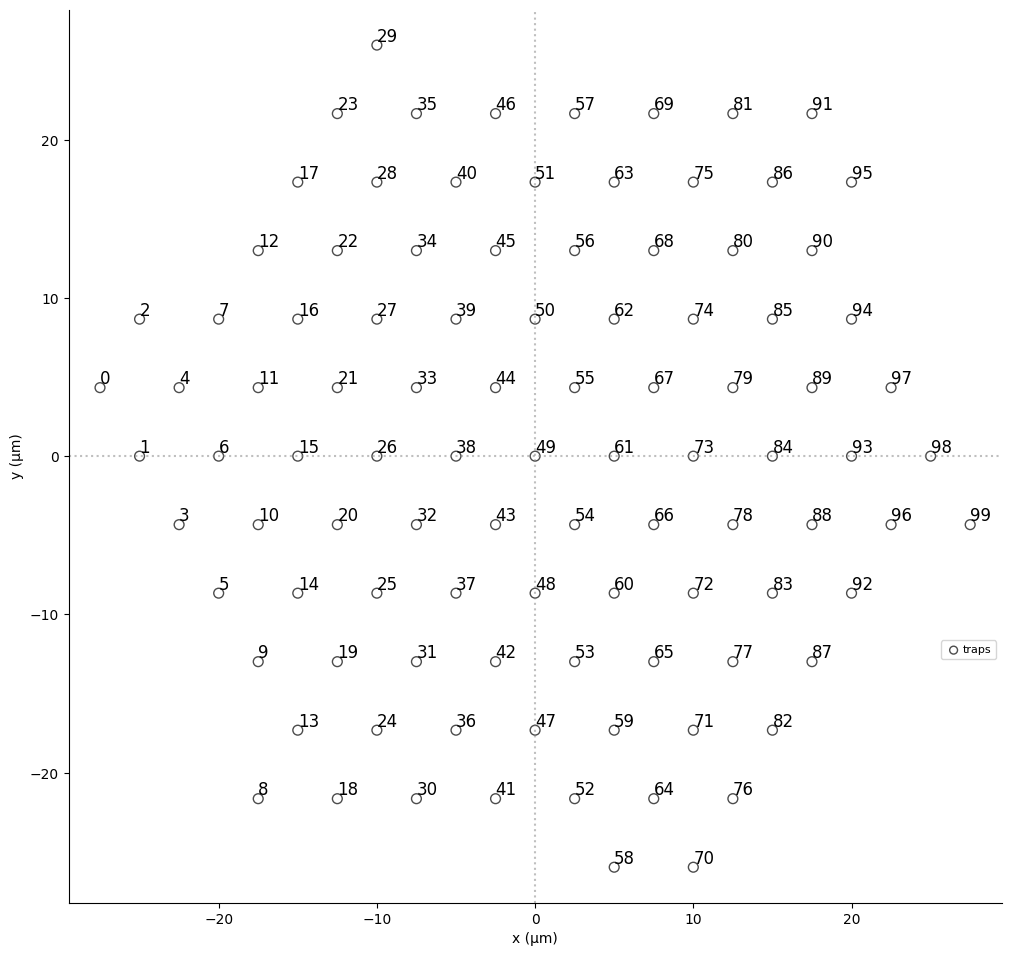

In [11]:
tri_layout = TriangularLatticeLayout(n_traps=100, spacing=5)
print(tri_layout)
tri_layout.draw()

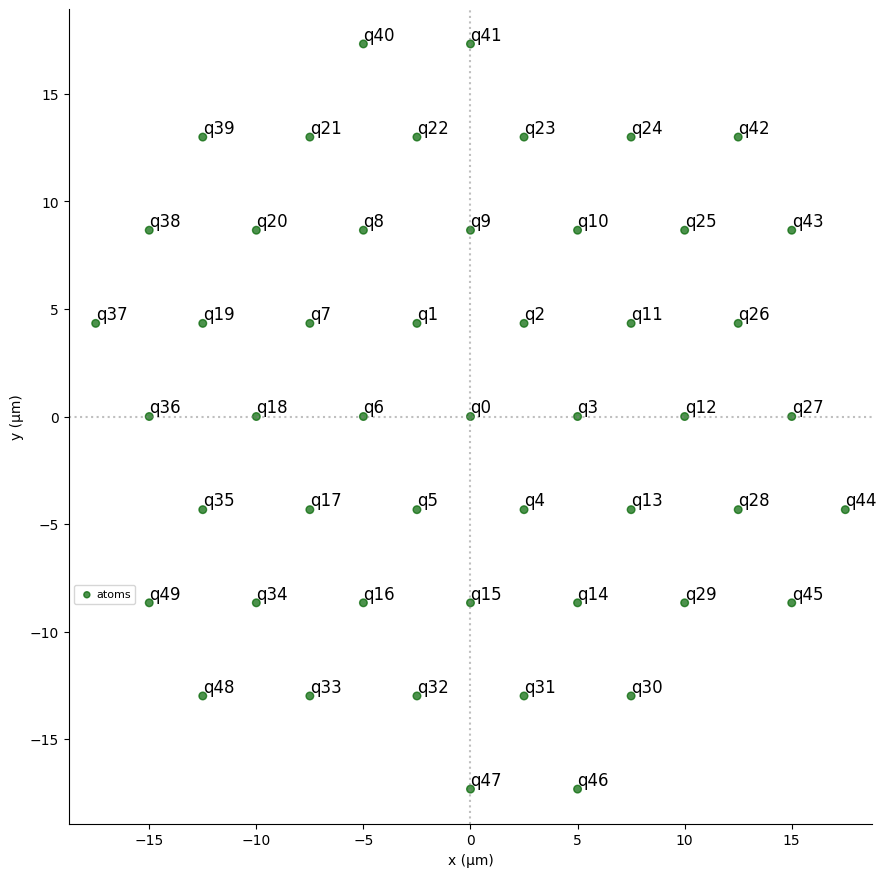

In [12]:
tri_layout.hexagonal_register(n_atoms=50).draw()

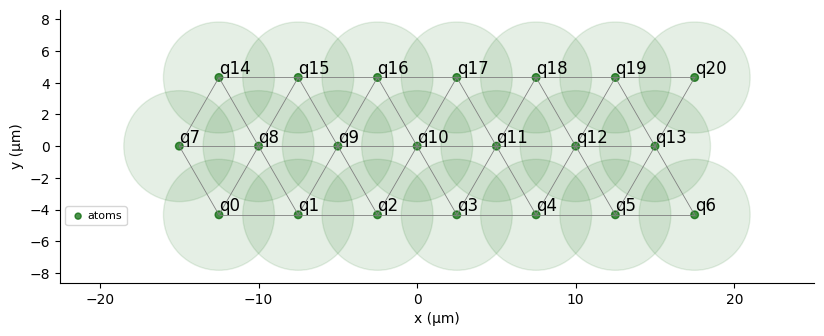

In [40]:
tri_layout.rectangular_register(rows=3, atoms_per_row=7).draw(
    blockade_radius=7,  # μm
    draw_half_radius=True,  # Draws circles with radius Rb/2
    draw_graph=True)

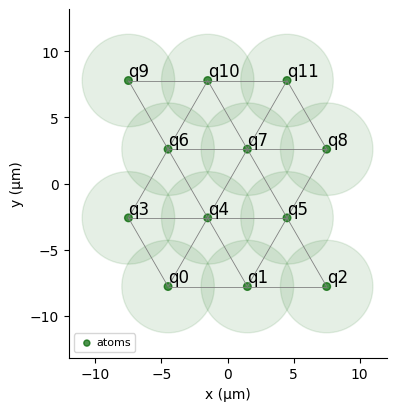

In [23]:
from pulser import Register

# 4x3 triangular lattice with 6μm spacing
tri_reg = Register.triangular_lattice(
    rows=4, atoms_per_row=3, spacing=6.0, prefix="q"
)
# Draw the interactions for Rb=7 μm
tri_reg.draw(
    blockade_radius=7,  # μm
    draw_half_radius=True,  # Draws circles with radius Rb/2
    draw_graph=True,  # Draws edges between interacting atoms
)

# 4. Devices with pre-calibrated layouts

In [14]:
from pulser.devices import Device
from pulser.channels import Rydberg, Raman

TestDevice = Device(
    name="TestDevice",
    dimensions=2,
    rydberg_level=70,
    max_atom_num=100,
    max_radial_distance=50,
    max_layout_filling=0.4,
    min_atom_distance=4,
    channel_objects=(Rydberg.Global(2 * np.pi * 20, 2 * np.pi * 2.5),),
    pre_calibrated_layouts=(
        SquareLatticeLayout(10, 10, 4),
        TriangularLatticeLayout(100, 5),
    ),
)

In [15]:
TestDevice.calibrated_register_layouts

{'SquareLatticeLayout(10x10, 4.0µm)': RegisterLayout_e0a40bea81ea9f3ef63dfbb16ee1fa85138e50a9402b1fa04822994b055c0b4f,
 'TriangularLatticeLayout(100, 5.0µm)': RegisterLayout_46d398a85ffbed2af2918ecfc59fe0ab265ee3ffdea3d734774bee2fc5c90145}

In [34]:
layout = TestDevice.calibrated_register_layouts[
    "SquareLatticeLayout(10x10, 4.0µm)"
]
reg = layout.square_register(6)
seq = Sequence(reg, TestDevice)

In [35]:
another_layout = SquareLatticeLayout(5, 5, 5)
assert another_layout not in TestDevice.pre_calibrated_layouts
reg_ = another_layout.square_register(3)
seq = Sequence(reg_, TestDevice)

In [36]:
bad_layout = TriangularLatticeLayout(
    200, 10
)  # This layout is too large for TestDevice
good_reg = bad_layout.hexagonal_register(
    10
)  # On its own, this register is valid in TestDevice
try:
    seq = Sequence(good_reg, TestDevice)
except ValueError as e:
    print(e)

The 'register' is associated with an incompatible register layout.


In [37]:
layout = TestDevice.calibrated_register_layouts[
    "SquareLatticeLayout(10x10, 4.0µm)"
]
too_big_reg = layout.square_register(7)
try:
    seq = Sequence(too_big_reg, TestDevice)
except ValueError as e:
    print(e)

Given the number of traps in the layout and the device's maximum layout filling fraction, the given register has too many qubits (49). On this device, this layout can hold at most 40 qubits.


In [38]:
map_register = layout.make_mappable_register(n_qubits=10)
map_register.qubit_ids

('q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9')

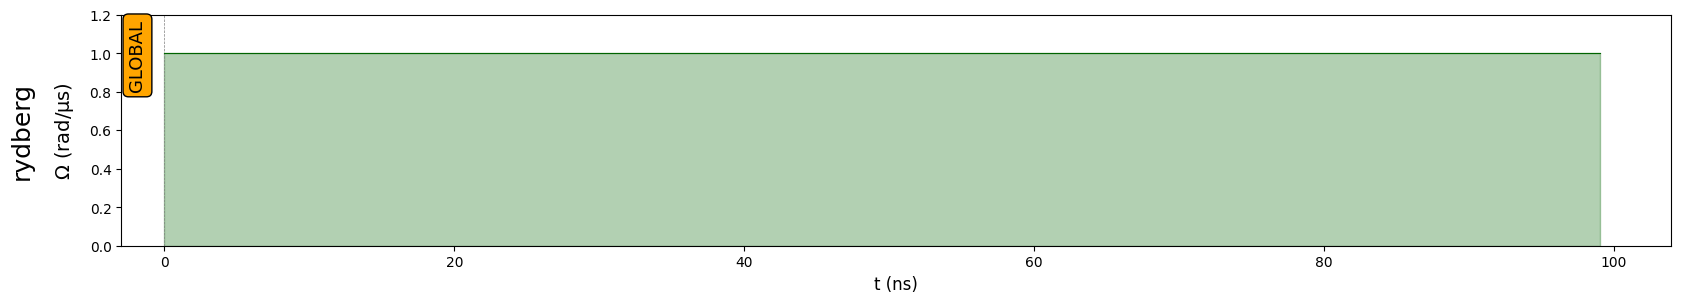

In [39]:
seq = Sequence(map_register, TestDevice)
assert seq.is_register_mappable()

seq.declare_channel("rydberg", "rydberg_global")
seq.add(
    Pulse.ConstantPulse(duration=100, amplitude=1, detuning=0, phase=0),
    "rydberg",
)
seq.draw()

In [22]:
seq1 = seq.build(qubits={"q0": 16, "q1": 19, "q2": 34})
print("First register:", seq1.register.qubits)

seq2 = seq.build(qubits={"q0": 0, "q2": 15, "q1": 20, "q3": 50})
print("Second register:", seq2.register.qubits)

First register: {'q0': array([-12.,   8.]), 'q1': array([-12.,  20.]), 'q2': array([-4.,  0.])}
Second register: {'q0': array([-16., -16.]), 'q1': array([ -8., -16.]), 'q2': array([-12.,   4.]), 'q3': array([  4., -16.])}


# 5. QEK-ML register

5.1 100 qubits

In [67]:
from pulser.register import Register3D

qek_ml_register = Register3D.cuboid(rows=5, columns=5, layers=4, spacing=7)

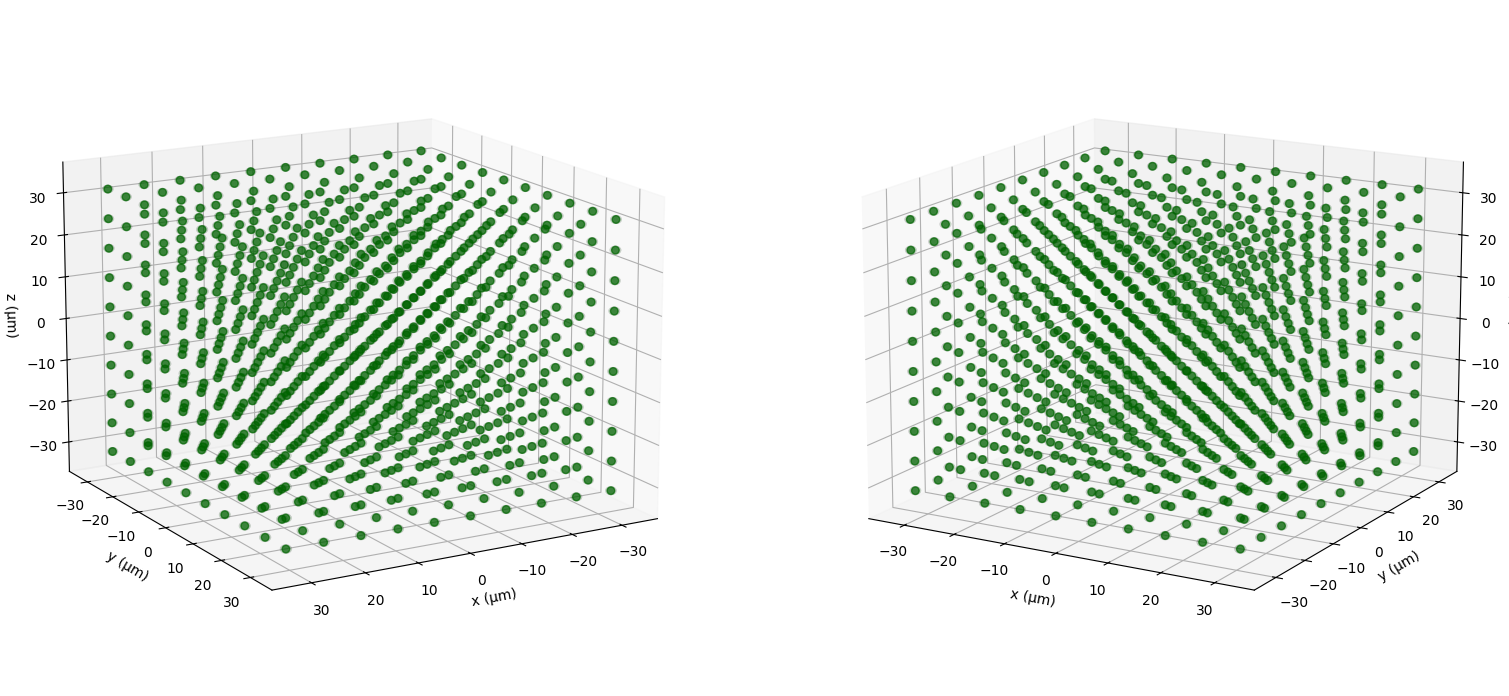

In [73]:
qek_ml_register.draw(draw_graph=True, draw_half_radius=True, blockade_radius=2)

5.2 1000 qubits

In [69]:
from pulser.register import Register3D

qek_ml_register = Register3D.cuboid(rows=10, columns=10, layers=10, spacing=7)

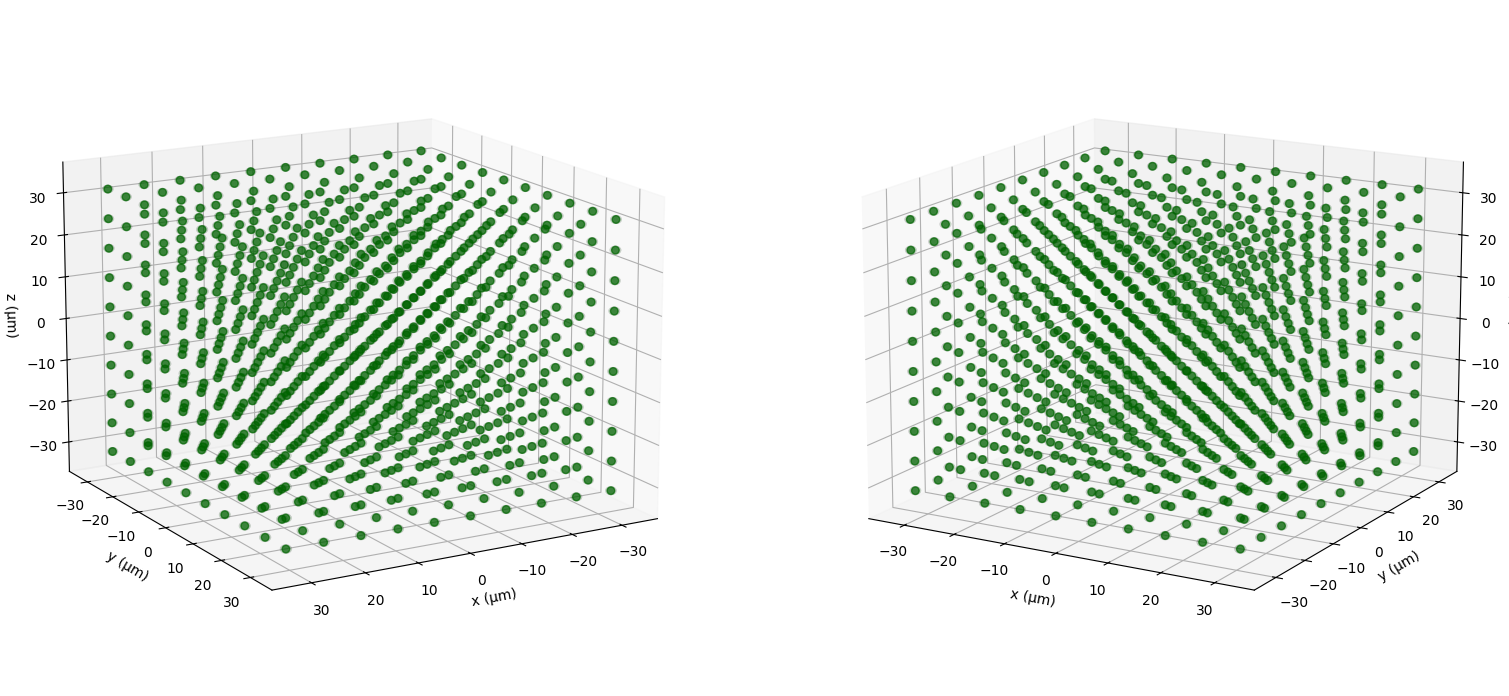

In [72]:
qek_ml_register.draw(draw_graph=True, draw_half_radius=True, blockade_radius=2)